### Learn Sobel Filter via CNN

In this notebook we will demonstrate how to train a simple CNN to learn to perform Sobel filtering (first order spatial derivatives). We will also see that a CNN can be thought of as a generic model and can be used to approximate any generic image processing algorithm. This is especially useful if a CNN-based implementation is much faster (usually with the aid of GPU or similar dedicated units) than the original algorithm implementation.

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

#### Dataset

We will try to keep it simple. Therefore, we will use one image (any image will do) and its corresponding Sobel derivative.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x219bb8c3280>)

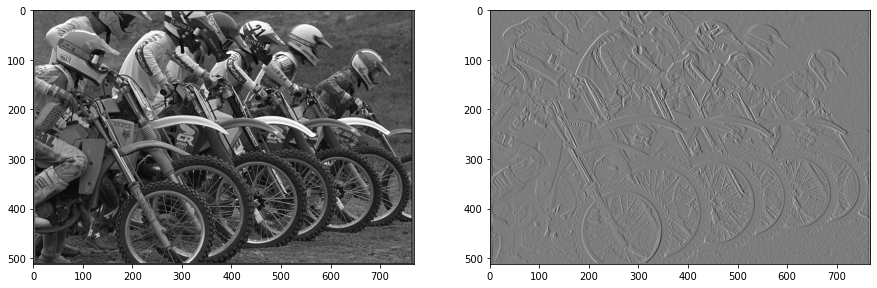

In [3]:
# Load image and convert to gray-scale
img = cv2.imread('./data/kodim05.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Select x or y spatial derivative
sobel = 'x'

if sobel == 'x':
    out = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0)
elif sobel == 'y':
    out = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=0, dy=1)
else:
    raise NotImplemented

plt.subplot(121), plt.imshow(img, cmap='gray')
plt.subplot(122), plt.imshow(out, cmap='gray')

In [4]:
print(img[100:103, 100:103])
print(out[100:103, 100:103])

[[130  94  49]
 [145 149 128]
 [141 144 152]]
[[-155. -193. -182.]
 [ -37. -104. -228.]
 [   6.    4.  -76.]]


#### Data Generator

In this example, we will implement a data generator. So far we have been loading the entire dataset in memory and use it for training. However, in many cases, this is not possible since the dataset is simply too big to fit in memory (this is not the case of this example, though). Therefore, we will need to fetch the data batches from disk as they are requested for training purposes (the so called online fetching). For that, python provide us with the generator functions.

In [5]:
def datagen(img, win=128, batch_size=16):
    rows, cols = img.shape
    
    while True:
        batch_x, batch_y = [], []
        for _ in range(batch_size):
            # Select any random image patch (region)
            r_init = np.random.randint(win, rows-win)
            c_init = np.random.randint(win, cols-win)
            
            # Generate inputs and labels
            x_sample = img[r_init:r_init+win, c_init:c_init+win]
            y_sample = out[r_init:r_init+win, c_init:c_init+win]
            
            # Normalize
            x_sample = (x_sample - np.mean(x_sample))/np.std(x_sample)
            y_sample = (y_sample - np.mean(y_sample))/np.std(y_sample)
            
            # Build batches
            batch_x.append(x_sample)
            batch_y.append(y_sample)
            
        yield np.array(batch_x).astype(np.float32), np.array(batch_y).astype(np.float32)

Let's now demonstrate how data generators work.

In [6]:
# Create data generator
dg = datagen(img)

# Request next sample
x, y = next(dg)

print(x.shape, y.shape)

(16, 128, 128) (16, 128, 128)


### Building the Network

The objective is to build a network that will learn to approximate the Sobel operator. The Sobel operator that we use in this example is the classic 3x3 kernel. Therefore, our CNN will consists of one single 3x3 convolutional kernel. And since we are interested in approximate the kernel values, we are not applying any non-linearities to the output.

In [7]:
inputs = Input(shape=(128, 128, 1))
outputs = Conv2D(1, kernel_size=(3, 3), activation="linear", padding='same')(inputs)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 1)       10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Note that, unlike the classic Sobel filter, the convolutional kernel includes one more parameter: the bias.

#### Training

Let's now train the network using the data generator. The objective funciton is the MSE (since we want the output to approximate the Sobel derivative). Furthermore, note that since we are using data generators, we need to specify the number of steps per epoch (since the generator is basically an inifinite loop providing data, the trainer does not know how long one epoch lasts).

In [8]:
epochs = 10
model.compile(loss="mse", optimizer="adam", metrics=["mse"])

start = time()
history = model.fit(dg, steps_per_epoch=1000, epochs=epochs, verbose=1)
print('Elapsed time', time() - start)

Epoch 1/10
  13/1000 [..............................] - ETA: 25s - loss: 1.3777 - mse: 1.3777

KeyboardInterrupt: 

#### Checking the Learnt Kernel

We are now going to check the value of the kernel that the network has learnt. In order to do so, we are going to extract the weights and the bias fomr the (only) convolutional kernel.

In [ ]:
weights, bias = model.layers[-1].get_weights()
print(weights, bias)

Remember that the network does not know that it has to learn the exact Sobel filter (with the exact scale). Note that the output of the Sobel filter and any of its scaled versions is exactly the same (remember we have normalized the data). Therefore, in order to better visualize the learnt values, we are going to normalize the kernel so its top-left value is equal to 1 (which is true for Sobel kernels in both x and y direction).

In [ ]:
# Remove the unit dimensions
weights = weights.squeeze()

# Normalize
weights = weights/weights[0,0]
print(weights)

#### Evaluation

We already know that the kernel approximates quite accurately the Sobel filter. In order to visually demonstrate that, we are going to filter the input image with the learnt kernel (and sum the bias) and compare it to the original derivative image.

In [ ]:
# Compute the estimated spatial derivative using the trained filter
est = cv2.filter2D(img, ddepth=cv2.CV_32F, kernel=-weights) + bias

# Compare the results
plt.subplot(121), plt.imshow(out, cmap='gray'), plt.title('Sobel')
plt.subplot(122), plt.imshow(est, cmap='gray'), plt.title('CNN approximation')